In [1]:
import sys
sys.path.append('/workspace/Documents')
# imports
import os, sys

# third party imports
import numpy as np 
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import voxelmorph as vxm
import neurite as ne
import pandas as pd
import random
import nibabel as nb

from tensorflow.keras.utils import Sequence
import Diffusion_motion_field.Build_lists.Build_list as Build_list
import Diffusion_motion_field.functions_collection as ff
import Diffusion_motion_field.Data_processing as Data_processing

main_path = '/mnt/camca_NAS/4DCT'

2025-01-14 02:03:17.634864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# random function
def random_rotate(i, z_rotate_degree = None, z_rotate_range = [0,0], fill_val = None, order = 0):
    # only do rotate according to z (in-plane rotation)
    if z_rotate_degree is None:
        z_rotate_degree = random.uniform(z_rotate_range[0], z_rotate_range[1])

    if fill_val is None:
        fill_val = np.min(i)
    
    if z_rotate_degree == 0:
        return i, z_rotate_degree
    else:
        return Data_processing.rotate_image(np.copy(i), [0,0,z_rotate_degree], order = order, fill_val = fill_val, ), z_rotate_degree

def random_translate(i, x_translate = None,  y_translate = None, translate_range = [-10,10]):
    # only do translate according to x and y
    if x_translate is None or y_translate is None:
        x_translate = int(random.uniform(translate_range[0], translate_range[1]))
        y_translate = int(random.uniform(translate_range[0], translate_range[1]))

    return Data_processing.translate_image(np.copy(i), [x_translate,y_translate,0]), x_translate,y_translate

### build model

In [3]:
input_shape = [160,160,96]

nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]
vxm_model = vxm.networks.VxmDense(input_shape, nb_features, int_steps=0)


# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

2025-01-06 16:50:51.492515: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-01-06 16:50:51.493177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-01-06 16:50:51.514184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-06 16:50:51.516326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.50GiB deviceMemoryBandwidth: 1.41TiB/s
2025-01-06 16:50:51.516342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2025-01-06 16:50:51.518307: I tensorflow/stream_executor/platform/defau

### build generator

In [4]:
class DataGenerator(Sequence):

    def __init__(self,
        patient_class_list,
        patient_id_list,
        patient_num = None, 
        batch_size = None, 
        shuffle = None,
        normalize = None,
        adapt_shape = [160,160,96],
        augment = None,
        augment_frequency = None,
        seed = 10):

        self.patient_class_list = patient_class_list
        self.patient_id_list = patient_id_list
        self.patient_num = patient_num
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.normalize = normalize
        self.adapt_shape = adapt_shape
        self.augment = augment
        self.augment_frequency = augment_frequency
        self.seed = seed

        self.on_epoch_end()
        
    def __len__(self):
        return self.patient_id_list.shape[0] // self.batch_size

    def on_epoch_end(self):
        
        self.seed += 1
        self.index_array = np.random.permutation(self.patient_num)
        # print('all indexes array: ', self.index_array)

    def __getitem__(self,index):
        'Generate indexes of the batch'
        total_num = self.patient_num
        current_index = (index * self.batch_size) % total_num
        if total_num > current_index + self.batch_size:   # the total number of cases is adequate for next loop
            current_batch_size = self.batch_size
        else:
            current_batch_size = total_num - current_index  # approaching to the tend, not adequate, should reduce the batch size

        indexes = self.index_array[current_index : current_index + current_batch_size]
        # print('indexes in this batch: ',self.index_array,' and we pick: ', indexes) 

        # set memory 
        batch_moving_image = np.zeros(tuple([current_batch_size]) + tuple([self.adapt_shape[0],self.adapt_shape[1], self.adapt_shape[2]]) + tuple([1]))
        batch_fixed_image = np.zeros(tuple([current_batch_size]) + tuple([self.adapt_shape[0],self.adapt_shape[1], self.adapt_shape[2]]) + tuple([1]))
        batch_zero_phi = np.zeros(tuple([current_batch_size]) + tuple([self.adapt_shape[0],self.adapt_shape[1], self.adapt_shape[2]]) + tuple([len(self.adapt_shape)]))
        
 
        for i,j in enumerate(indexes):
            # get patient class and patient id
            patient_class = self.patient_class_list[j]
            patient_id = self.patient_id_list[j]
            path = os.path.join(main_path,'nii-images' ,patient_class, patient_id,'img-nii-resampled-1.5mm')
            print('patient class: ', patient_class, 'patient id: ', patient_id, ' path: ', path)

            # find out all files
            files = ff.sort_timeframe(ff.find_all_target_files(['*.nii.gz'],path),2)
            # print(' tf_num: ', len(files))
            random_integer = random.randint(1, len(files)- 1)
            two_tf = [random_integer, 0]
            # print('we pick two timeframes: ', two_tf, ' so the moving image is: ', files[two_tf[0]], ' the fixed image is: ', files[two_tf[1]])

            # load two timeframes
            tf1 = nb.load(files[two_tf[0]]).get_fdata()
            tf2 = nb.load(files[two_tf[1]]).get_fdata()
            if  len(tf1.shape) == 4:
                tf1 = tf1[:,:,:,0]
            if len(tf2.shape) == 4:
                tf2 = tf2[:,:,:,0]

            # adapt shape
            if self.adapt_shape != None:
                tf1 = Data_processing.crop_or_pad(tf1, self.adapt_shape, value = np.min(tf1))
                tf2 = Data_processing.crop_or_pad(tf2, self.adapt_shape, value = np.min(tf2))
            
            # normalize
            if self.normalize == True:
                tf1 = Data_processing.normalize_image(tf1, normalize_factor=1000)
                tf2 = Data_processing.normalize_image(tf2, normalize_factor = 1000)

            # augment
            if self.augment == True:
                if random.uniform(0,1) < self.augment_frequency:
                    tf1, z_rotate_degree = random_rotate(tf1,  z_rotate_range = [-10,10], order = 2)
                    tf1, x_translate, y_translate = random_translate(tf1, translate_range = [-10,10])
                    tf2, _ = random_rotate(tf2, z_rotate_degree = z_rotate_degree, order = 2)
                    tf2, _, _ = random_translate(tf2, x_translate = x_translate, y_translate = y_translate)
                    print('z_rotate_degree: ', z_rotate_degree, ' x_translate: ', x_translate, ' y_translate: ', y_translate)
            
            tf1 = np.expand_dims(tf1, axis = -1); tf2 = np.expand_dims(tf2, axis = -1)

            batch_moving_image[i] = tf1
            batch_fixed_image[i] = tf2
        
        # print('batch_moving_image: ', batch_moving_image.shape, ' batch_fixed_image: ', batch_fixed_image.shape, ' batch_zero_phi: ', batch_zero_phi.shape)

        inputs = [batch_moving_image, batch_fixed_image]
        outputs = [batch_fixed_image, batch_zero_phi]

        return (inputs, outputs)

### set the data

In [5]:
data_sheet = os.path.join(main_path,'Patient_lists/patient_list_train_test.xlsx')

b = Build_list.Build(data_sheet)
patient_class_train_list, patient_id_train_list = b.__build__(batch_list = [0]) 
# patient_id_train_list = np.asarray(patient_id_train_list[0:1])
# patient_class_train_list = np.asarray(patient_class_train_list[0:1])
print(patient_id_train_list.shape)

(81,)


In [87]:
batch_size = 1
train_generator = DataGenerator(
        patient_class_train_list,
        patient_id_train_list,
        patient_num = len(patient_id_train_list),
        batch_size = batch_size,
        shuffle = True,
        normalize = True,
        adapt_shape = [160,160,96],
        augment = None,
        augment_frequency = 0.5,
        seed = 10)
val_generator = DataGenerator(
        patient_class_train_list,
        patient_id_train_list,
        patient_num = len(patient_id_train_list),
        batch_size = batch_size, 
        shuffle = False,
        normalize = True,
        adapt_shape = [160,160,96],
        augment = None,
        seed = 10)

all indexes array:  [0]
all indexes array:  [0]


### train

In [116]:
trial_name = 'trial_1'
save_path = os.path.join(main_path, 'models', trial_name)
ff.make_folder([save_path, os.path.join(save_path, 'logs')])
pre_epoch = 441
if pre_epoch != None:
    pre_model = os.path.join(save_path, 'vxm_model_epoch' + str(pre_epoch) + '.h5')
print('pre_epoch: ', pre_model, pre_epoch)

pre_epoch:  /mnt/camca_NAS/4DCT/models/vxm_model_epoch441.h5 441


In [117]:
validation_every_epoch = 20  # Validate every N epochs
nb_epochs = 2000

# Initialize an Excel sheet data storage
excel_results = []

if pre_epoch!= None:
    vxm_model.load_weights(pre_model)
    print('pre-trained model loaded')
    start_epoch = pre_epoch
else:
    start_epoch = 0

# Training loop
for epoch in range(start_epoch , start_epoch + nb_epochs):
    print(f"Epoch {epoch + 1}/{nb_epochs}")

    # Train the model for one epoch
    hist = vxm_model.fit(
        train_generator,
        epochs=1,
        verbose=1
    )

    # Get the training loss
    training_loss = hist.history['loss'][0]
    transformer_loss = hist.history.get('vxm_dense_transformer_loss', [None])[0]
    flow_loss = hist.history.get('vxm_dense_flow_loss', [None])[0]


    # Calculate validation loss every N epochs
    if epoch % validation_every_epoch == 0:
        val_hist = vxm_model.evaluate(val_generator, verbose=1, return_dict=True)
        val_loss = val_hist['loss']
        val_transformer_loss = val_hist.get('vxm_dense_transformer_loss', None)
        val_flow_loss = val_hist.get('vxm_dense_flow_loss', None)
    
        epoch_results = [epoch + 1, training_loss, transformer_loss, flow_loss, val_loss, val_transformer_loss, val_flow_loss]
        print('epoch results:', epoch_results)
        excel_results.append(epoch_results)
        df = pd.DataFrame(excel_results, columns=['Epoch', 'Training Loss', 'Transformer Loss', 'Flow Loss', 'Validation Loss', 'Validation Transformer Loss', 'Validation Flow Loss'])
        file_name = os.path.join(save_path, 'logs/training_metrics.xlsx')
        df.to_excel(file_name, index=False)

        # Save the model parameters for each epoch
        vxm_model.save(os.path.join(save_path,'vxm_model_epoch'+str(epoch + 1)+'.h5'))
        print(f"Model saved as 'vxm_model_epoch_{epoch + 1}.h5'")



pre-trained model loaded
Epoch 442/2000
indexes in this batch:  [0]  and we pick:  [0]
patient class:  Normal patient id:  AN11_1801231052  path:  /mnt/camca_NAS/4DCT/nii-images/Normal/AN11_1801231052/img-nii-resampled-1.5mm
 tf_num:  16
we pick two timeframes:  [12, 0]  so the moving image is:  /mnt/camca_NAS/4DCT/nii-images/Normal/AN11_1801231052/img-nii-resampled-1.5mm/12.nii.gz  the fixed image is:  /mnt/camca_NAS/4DCT/nii-images/Normal/AN11_1801231052/img-nii-resampled-1.5mm/0.nii.gz
batch_moving_image:  (1, 160, 160, 96, 1)  batch_fixed_image:  (1, 160, 160, 96, 1)  batch_zero_phi:  (1, 160, 160, 96, 3)
indexes in this batch:  [0]  and we pick:  [0]
patient class:  Normal patient id:  AN11_1801231052  path:  /mnt/camca_NAS/4DCT/nii-images/Normal/AN11_1801231052/img-nii-resampled-1.5mm
 tf_num:  16
we pick two timeframes:  [1, 0]  so the moving image is:  /mnt/camca_NAS/4DCT/nii-images/Normal/AN11_1801231052/img-nii-resampled-1.5mm/1.nii.gz  the fixed image is:  /mnt/camca_NAS/4DC

KeyboardInterrupt: 

### test

In [7]:
# hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);
vxm_model.load_weights(os.path.join('/mnt/camca_NAS/4DCT/models/voxel_morph/','vxm_model_epoch119.h5'))

In [36]:
i = 19
patient_id = patient_id_train_list[i]
patient_class = patient_class_train_list[i]
print(patient_class, patient_id)
path = os.path.join(main_path,'nii-images' ,patient_class, patient_id,'img-nii-resampled-1.5mm')
tf1 = nb.load(ff.sort_timeframe(ff.find_all_target_files(['*.nii.gz'],path),2)[5]).get_fdata()
tf2 = nb.load(ff.sort_timeframe(ff.find_all_target_files(['*.nii.gz'],path),2)[0]).get_fdata()
tf1 = Data_processing.crop_or_pad(tf1, [160,160,96], value = np.min(tf1)) / 1000
tf2 = Data_processing.crop_or_pad(tf2, [160,160,96], value = np.min(tf2)) / 1000
val_input = [ tf1[np.newaxis, ..., np.newaxis],
    tf2[np.newaxis, ..., np.newaxis]
]


Normal CVC1906051309


In [37]:
val_pred = vxm_model.predict(val_input)
moved_pred = val_pred[0].squeeze() * 1000
pred_warp = val_pred[1]

mae:  55.91752965184725


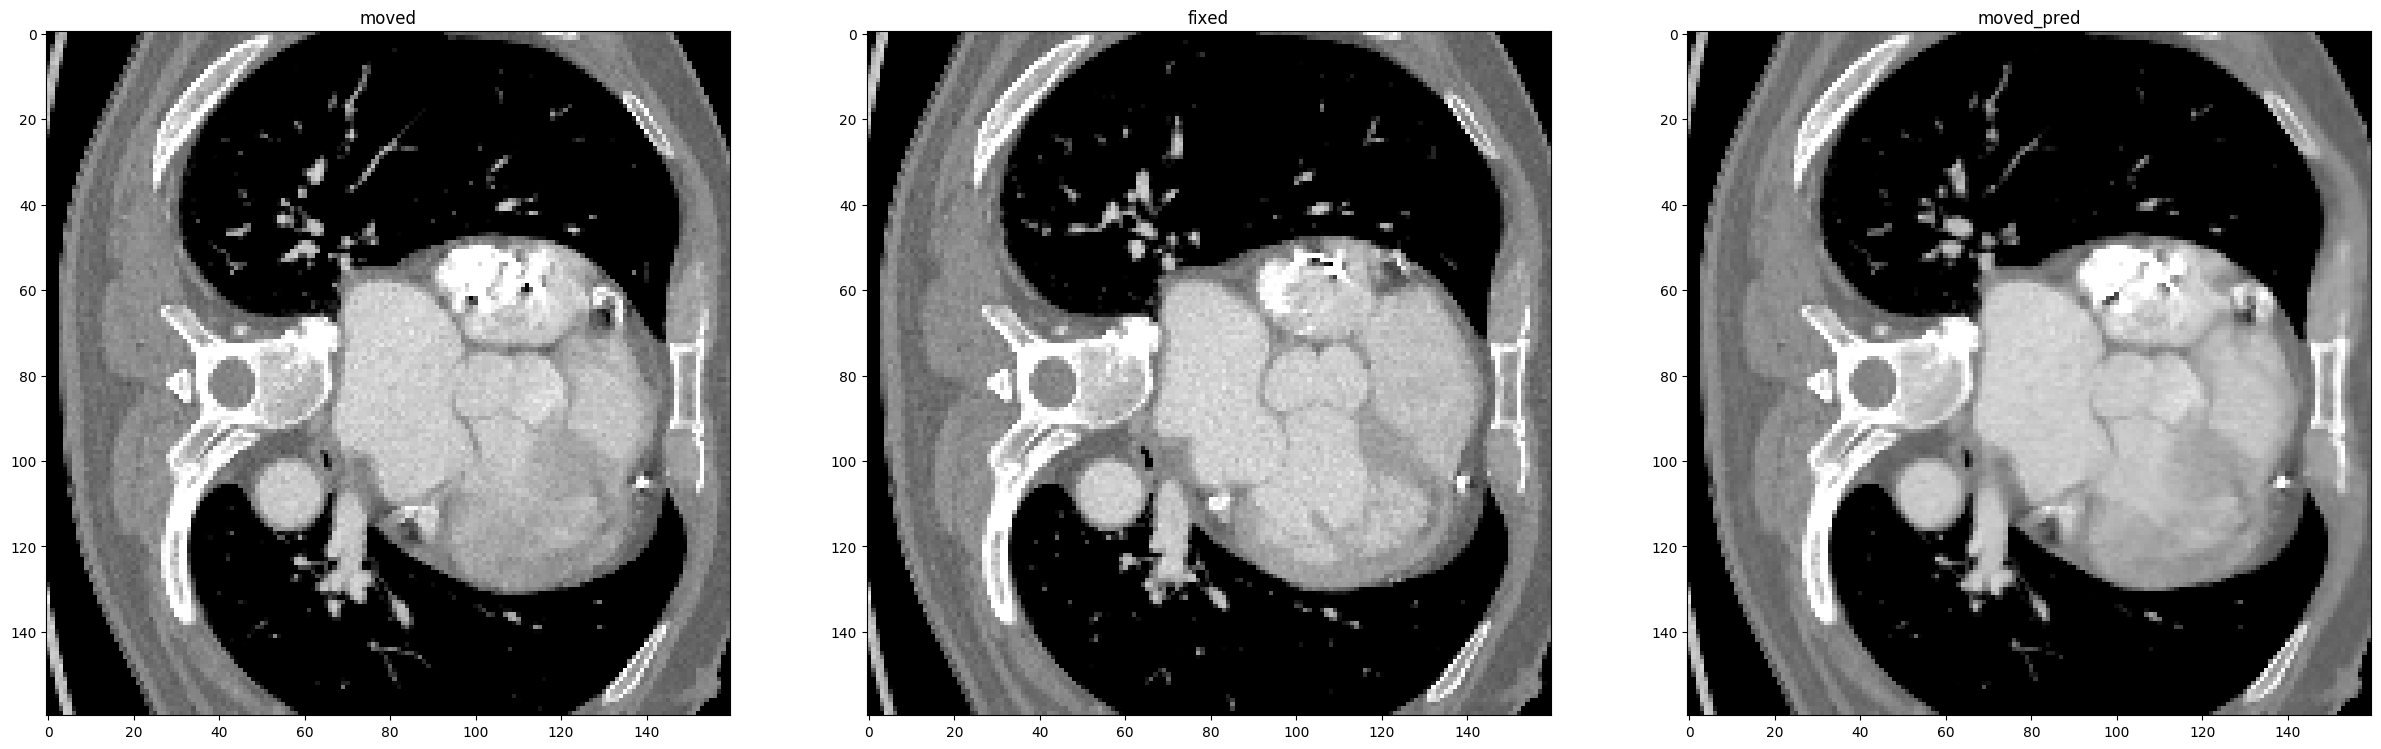

In [39]:
# plot tf1, tf2 ,moved_pred side by side, pick the middle slice, need to set figure size
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize = (30,10))
slice_num = 26
ax[0].imshow(ff.set_window(tf1[:,:,slice_num]*1000,0,1000), cmap = 'gray')
ax[0].set_title('moved')
ax[1].imshow(ff.set_window(tf2[:,:,slice_num]*1000,0,1000), cmap = 'gray')
ax[1].set_title('fixed')
ax[2].imshow(ff.set_window(moved_pred[:,:,slice_num],0,1000), cmap = 'gray')
ax[2].set_title('moved_pred')
# calculate mae between tf2 and moved_pred
mae = np.mean(np.abs(tf2*1000 - moved_pred))
print('mae: ', mae)


In [28]:
import numpy as np
from scipy.ndimage import map_coordinates

def apply_deformation_field_numpy(moving_image, deformation_field):
    """
    Apply a deformation field to the moving image using trilinear interpolation.

    Args:
        moving_image (np.ndarray): The moving image of shape [H, W, D].
        deformation_field (np.ndarray): The deformation field of shape [H, W, D, 3].

    Returns:
        np.ndarray: Warped image of shape [H, W, D].
    """
    # Get the grid of coordinates
    H, W, D = moving_image.shape
    grid_x, grid_y, grid_z = np.meshgrid(
        np.arange(H), np.arange(W), np.arange(D), indexing='ij'
    )

    # Add the deformation field to the grid
    deformed_x = grid_x + deformation_field[..., 0]
    deformed_y = grid_y + deformation_field[..., 1]
    deformed_z = grid_z + deformation_field[..., 2]

    # Flatten the coordinates for interpolation
    coordinates = np.array([deformed_x.flatten(), deformed_y.flatten(), deformed_z.flatten()])

    # Interpolate using map_coordinates
    warped_image = map_coordinates(moving_image, coordinates, order=1, mode='nearest').reshape(H, W, D)

    return warped_image


# Example usage
# Moving image (3D): [H, W, D]
moving_image = np.random.rand(160, 160, 96)

# Deformation field (3D): [H, W, D, 3]
deformation_field = np.random.randn(160, 160, 96, 3) * 0.1  # Small random deformation field

# Generate the warped image
warped_image = apply_deformation_field_numpy(moving_image, deformation_field)

print("Warped image shape:", warped_image.shape)


Warped image shape: (160, 160, 96)


mae:  0.00022630491657097952


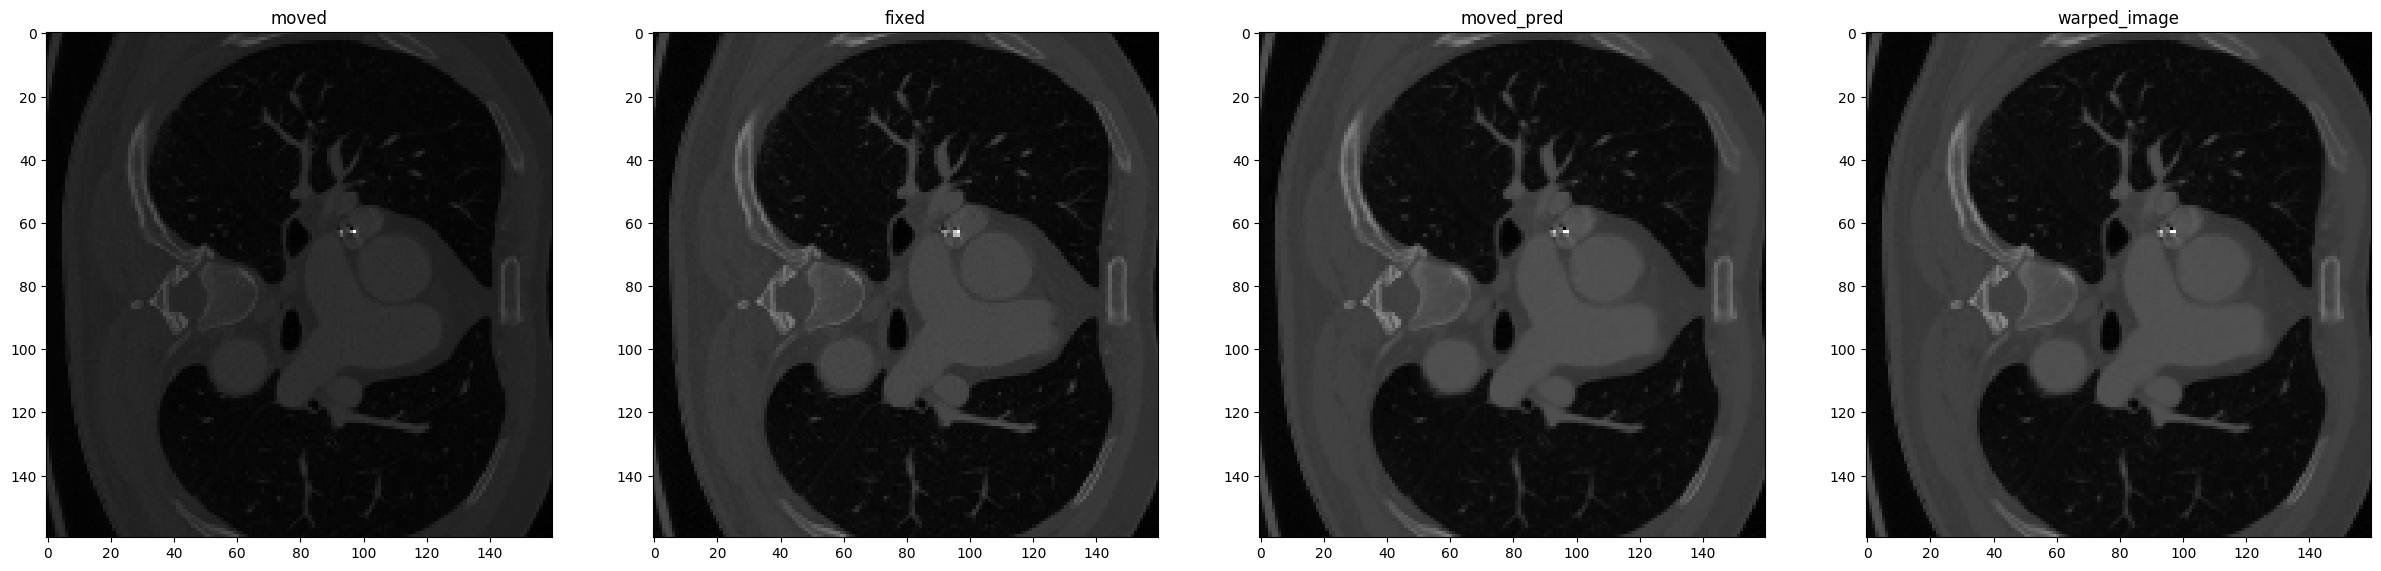

In [29]:
moving_image = tf1
deformation_field = pred_warp.squeeze()
warped_image = apply_deformation_field_numpy(moving_image, deformation_field)

# plot tf1, tf2 ,moved_pred side by side, pick the middle slice, need to set figure size
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,4, figsize = (30,10))
ax[0].imshow(tf1[:,:,50]*1000, cmap = 'gray')
ax[0].set_title('moved')
ax[1].imshow(tf2[:,:,50]*1000, cmap = 'gray')
ax[1].set_title('fixed')
ax[2].imshow(moved_pred[:,:,50], cmap = 'gray')
ax[2].set_title('moved_pred')
ax[3].imshow(warped_image[:,:,50]*1000, cmap = 'gray')
ax[3].set_title('warped_image')
# calculate mae between tf2 and moved_pred
mae = np.mean(np.abs(warped_image*1000 - moved_pred))
print('mae: ', mae)


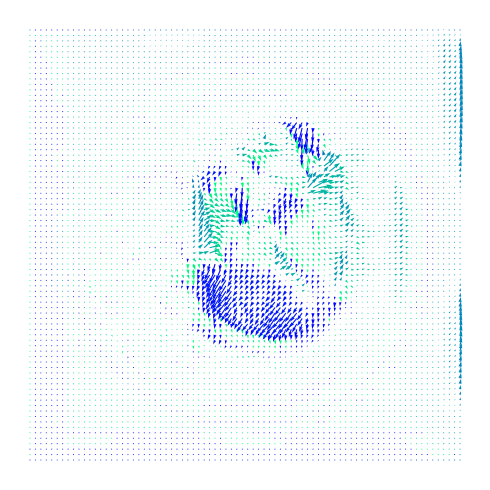

5.637123 -4.5053444


In [11]:
# visualize flow
flow = val_pred[1].squeeze()[::2,::2,50,0:2]
ne.plot.flow([flow], width=5)
print(np.max(val_pred[1].squeeze()), np.min(val_pred[1].squeeze()))

### apply mvf

In [104]:
import sys
sys.path.append('/workspace/Documents')
# imports
import os, sys

# third party imports
import numpy as np 
import pandas as pd
import random
import nibabel as nb

import Diffusion_motion_field.Build_lists.Build_list as Build_list
import Diffusion_motion_field.functions_collection as ff
import Diffusion_motion_field.Data_processing as Data_processing

main_path = '/mnt/camca_NAS/4DCT'

In [105]:
import numpy as np
from scipy.ndimage import map_coordinates

def apply_deformation_field_numpy(moving_image, deformation_field):
    """
    Apply a deformation field to the moving image using trilinear interpolation.

    Args:
        moving_image (np.ndarray): The moving image of shape [H, W, D].
        deformation_field (np.ndarray): The deformation field of shape [H, W, D, 3].

    Returns:
        np.ndarray: Warped image of shape [H, W, D].
    """
    # Get the grid of coordinates
    H, W, D = moving_image.shape
    grid_x, grid_y, grid_z = np.meshgrid(
        np.arange(H), np.arange(W), np.arange(D), indexing='ij'
    )

    # Add the deformation field to the grid
    deformed_x = grid_x + deformation_field[..., 0]
    deformed_y = grid_y + deformation_field[..., 1]
    deformed_z = grid_z + deformation_field[..., 2]

    # Flatten the coordinates for interpolation
    coordinates = np.array([deformed_x.flatten(), deformed_y.flatten(), deformed_z.flatten()])

    # Interpolate using map_coordinates
    warped_image = map_coordinates(moving_image, coordinates, order=1, mode='nearest').reshape(H, W, D)

    return warped_image


# Example usage
# Moving image (3D): [H, W, D]
moving_image = np.random.rand(160, 160, 96)

# Deformation field (3D): [H, W, D, 3]
deformation_field = np.random.randn(160, 160, 96, 3) * 0.1  # Small random deformation field

# Generate the warped image
warped_image = apply_deformation_field_numpy(moving_image, deformation_field)

print("Warped image shape:", warped_image.shape)


Warped image shape: (160, 160, 96)


In [150]:
patient_class = 'Normal'
patient_id = 'CVC1904220946' # CVC1902221320 不同tf之间没有一一对应的slice
tf_num = 5
tf1 = nb.load(ff.sort_timeframe(ff.find_all_target_files(['*.nii.gz'],os.path.join(main_path,'nii-images',patient_class,patient_id,'img-nii-resampled-1.5mm')),2)[tf_num]).get_fdata()
tf2 = nb.load(ff.sort_timeframe(ff.find_all_target_files(['*.nii.gz'],os.path.join(main_path,'nii-images',patient_class,patient_id,'img-nii-resampled-1.5mm')),2)[0]).get_fdata()
tf1 = Data_processing.crop_or_pad(tf1, [160,160,96], value = np.min(tf1)) 
tf2 = Data_processing.crop_or_pad(tf2, [160,160,96], value = np.min(tf2))

mvf = nb.load(os.path.join(main_path,'mvf_new', patient_class, patient_id,'voxel_morph_val4_new_epoch119',str(tf_num)+'.nii.gz')).get_fdata()
# mvf = nb.load(os.path.join(main_path, 'models/MVF_downsampled_condition_on_img_trial1/pred_mvf', patient_class, patient_id,'epoch318','pred-epoch-318.nii.gz')).get_fdata()
print(np.max(mvf), np.min(mvf))

11.608116149902344 -9.561284065246582


In [121]:
max_index = np.unravel_index(np.argmax(mvf), mvf.shape)
print(max_index)

(44, 76, 84, 1)


Text(0.5, 1.0, 'diff')

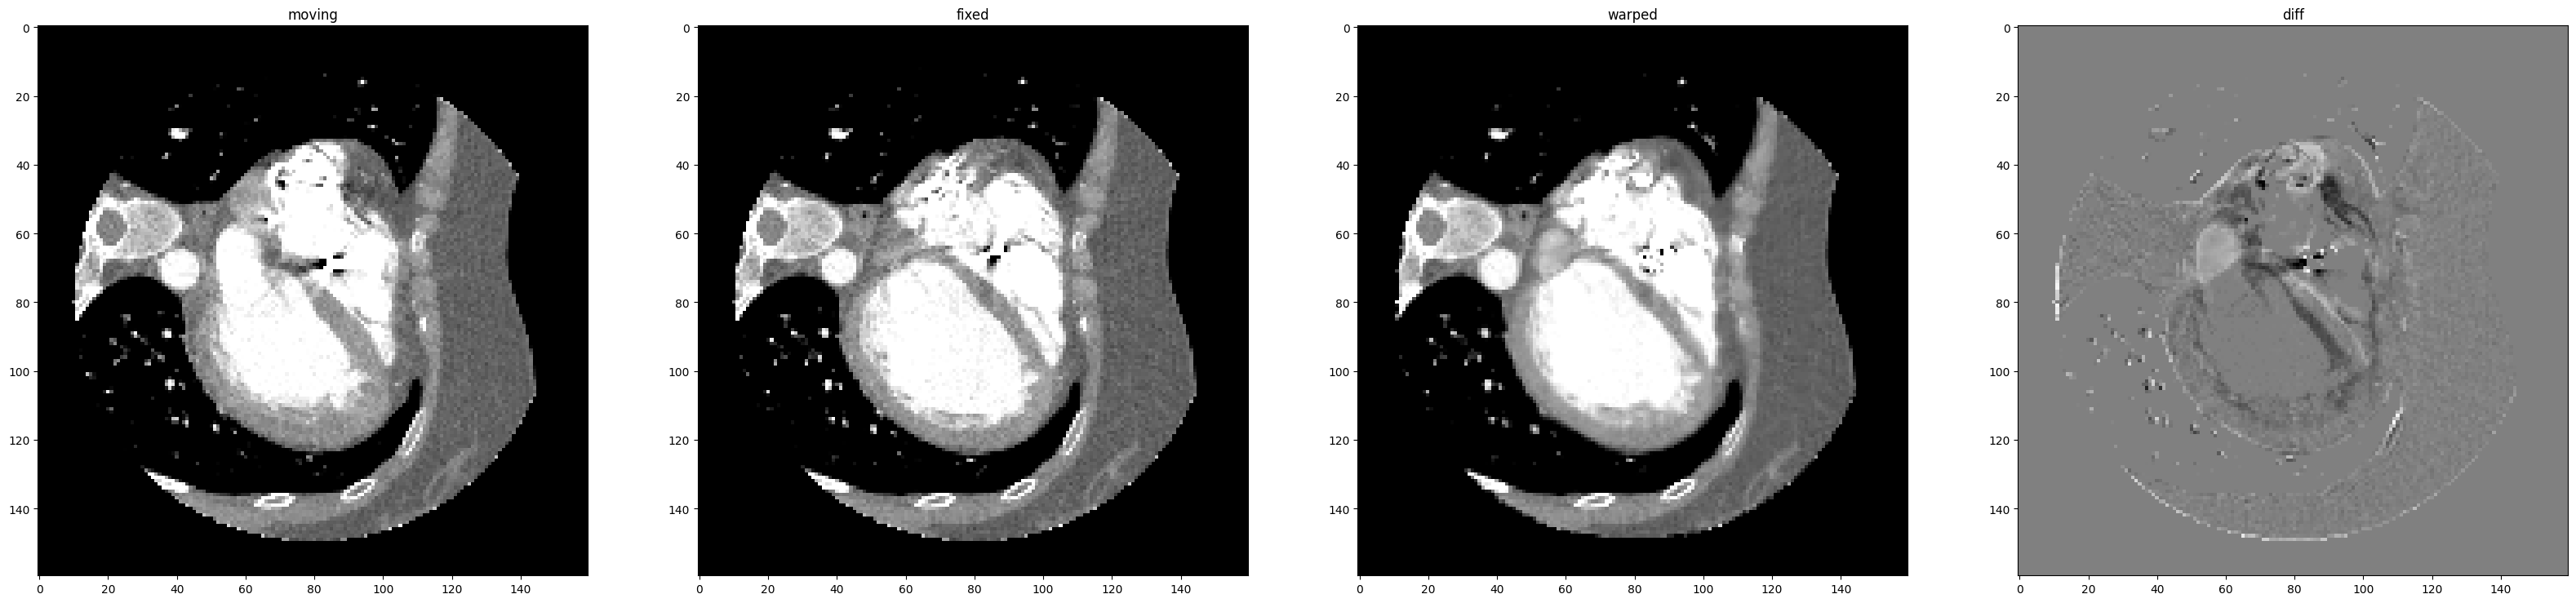

In [141]:
moving_image = tf2
deformation_field = -mvf
warped_image = apply_deformation_field_numpy(moving_image, deformation_field)

# plot moving image, tf2, warped_image side by side , slice = 50
import matplotlib.pyplot as plt
slice_n = 44
fig, ax = plt.subplots(1,4, figsize = (40,10))
tf11 = ff.set_window(tf1[:,:,slice_n], 0, 1000)
tf22 = ff.set_window(tf2[:,:,slice_n], 0, 1000)
warped_image1 = ff.set_window(warped_image[:,:,slice_n], 0, 1000)
ax[0].imshow(tf11, cmap = 'gray')
ax[0].set_title('moving')
ax[1].imshow(tf22, cmap = 'gray')
ax[1].set_title('fixed')
ax[2].imshow(warped_image1, cmap = 'gray')
ax[2].set_title('warped')
ax[3].imshow(tf11 - warped_image1, cmap = 'gray')
ax[3].set_title('diff')



### check the max and min of mvf

In [3]:
p = ff.find_all_target_files(['Normal/*','Abnormal/*'],os.path.join(main_path,'mvf_warp0_onecase'))

In [12]:
result = []
for i in range(0,len(p)):
    path = os.path.join(p[i],'voxel_final' )
    files = ff.find_all_target_files(['*.nii.gz'],path)
    final_files = np.copy(files)
    for f in files:
        if 'moved' in f or 'original' in f:
            # remove it from the numpy array
            final_files = np.delete(final_files, np.where(final_files == f))
    print(len(final_files))
    zz = np.zeros([160,160,96,3,len(final_files)])

    for j in range(0,len(final_files)):
        zz[:,:,:,:,j] = nb.load(final_files[j]).get_fdata()

    print(os.path.basename(p[i]),np.max(zz), np.min(zz))
    result.append([os.path.basename(os.path.dirname(p[i])),os.path.basename(p[i]), np.max(zz), np.min(zz)])
    df = pd.DataFrame(result, columns = ['patient_class', 'patient_id', 'max', 'min'])
    df.to_excel(os.path.join(main_path,'mvf_warp0_onecase','check_mvf_max_min.xlsx'), index = False)

16


AttributeError: module 'posixpath' has no attribute 'basenmae'